In [1]:
from pandas import read_csv
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
np.random.seed(0)
tf.random.set_seed(0)

In [10]:
def load_data(split):

    # Load train data
    data = read_csv('ds1-06-%d-nn-tr.csv' % split)
    X_train = data.iloc[:, :-1].to_numpy()
    y_train = data.iloc[:, -1].to_numpy()

    # Load test data
    data = read_csv('ds1-06-%d-nn-te.csv' % split)
    X_test = data.iloc[:, :-1].to_numpy()
    y_test = data.iloc[:, -1].to_numpy()
    
    # One-hot encoding
    y_train_OHE_OHE = to_categorical(y_train, num_classes=5)
    y_test_OHE_OHE = to_categorical(y_test, num_classes=5)

    return X_train, y_train, X_test, y_test, y_train_OHE_OHE, y_test_OHE_OHE

As many output neurons as categories --> use softmax and train with (pg44)

In [11]:
def create_model(layer_neurons, activation_function, learning_rate=0.1, metrics=['accuracy'], decay_steps=1000, decay_rate=0.96, loss_function='categorical_crossentropy', output_neurons=5, dynamic = False, optimizer = tf.keras.optimizers.SGD):
    model = tf.keras.models.Sequential()
    
    # Add hidden layers with specified number of neurons and activation function
    for neurons in layer_neurons:
        model.add(tf.keras.layers.Dense(neurons, activation=activation_function))
    
    if dynamic == True:
        lr = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate)
    else: # Para primeras tareas
        lr = learning_rate

    # Output layer with softmax activation for multi-class classification
    model.add(tf.keras.layers.Dense(output_neurons, activation='softmax'))

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer =  optimizer(learning_rate=lr), 
                  loss = loss_function, 
                  metrics = metrics)

    return model

### T1. Start with a basic configuration: a single hidden layer network and the most basic activation function. Try with three different amounts of neurons, and keep the best configuration for the next task.
### For training, set a fixed learning rate, the most basic optimizer, a reasonable batch size, the most direct loss function and choose enough epochs to let the training converge. Tune the learning rate until you achieve convergence and a reasonable performance. To measure performance, use the accuracy for the test set.


Now we can proceed to create a a one-layer network and try it on a different amount of neurons.

In [29]:
# Load data
X_train, y_train, X_test, y_test, y_train_OHE, y_test_OHE = load_data(1)

neurons_amount = [10,50,100]

for neurons in neurons_amount:
    promed = []
    model = create_model([neurons],  activation_function='relu')
    for i in range(5):
        model.fit(X_train, y_train_OHE, epochs = 10, batch_size = 256, verbose=0) # Quitar verbose para ver cada epoch
        performance = model.evaluate(X_test, y_test_OHE, verbose=0)
        promed.append(performance[1])
    print(f"Neurons: {neurons}, Test Accuracy (median): {np.mean(promed)}")

Neurons: 10, Test Accuracy (median): 0.657485032081604
Neurons: 50, Test Accuracy (median): 0.7550898194313049
Neurons: 100, Test Accuracy (median): 0.7928143858909606


In this task we used the `relu` activation function and the `sparse_categorical_crossentropy` as our lose function, due to we are facing a .........!!!! becauseAs it can see, the best performance is in the biggest amount, having an accuracy of 79%, bigger than the other amounts of neurons. So, we consider to take that amount of `100` neurons as the best configuration and test it for the following task

### T2. Next, check whether a change in the activation function of the hidden layer neurons improves the classification performance. If that is the case, continue with the alternative activation function.

In order to test if a change in the activation functions can work better then the previous one in T1, we are going to test it in a different amount of activation functions. With that, we will test the most used activation functions and we will be able to compare a reasonable amount of activation functions in order to choose the better one.

In [36]:
activation_functions = ['relu','sigmoid', 'tanh', 'leaky_relu', 'elu', 'selu'] 

for activation in activation_functions:
    model = create_model([100], activation)
    model.fit(X_train, y_train_OHE, epochs=10, batch_size=256, verbose=0)
    performance = model.evaluate(X_test, y_test_OHE, verbose=0)
    print(f"Neurons: {neurons}, Activation: {activation}, Test Accuracy: {performance[1]}")

Neurons: 100, Activation: relu, Test Accuracy: 0.703592836856842
Neurons: 100, Activation: sigmoid, Test Accuracy: 0.514970064163208
Neurons: 100, Activation: tanh, Test Accuracy: 0.7514970302581787
Neurons: 100, Activation: leaky_relu, Test Accuracy: 0.688622772693634
Neurons: 100, Activation: elu, Test Accuracy: 0.703592836856842
Neurons: 100, Activation: selu, Test Accuracy: 0.757485032081604


As it is shown, the best performance of the activations is the `relu` activation, reaching a 92% of accuracy. Having a good puntuation but still smaller than our prior configuration, that wins in terms of accuracy.

#### T3. Try with a dynamic learning rate and use it from now on if the performance does not get worse

In [47]:
model = create_model(
    layer_neurons=[100],
    activation_function='selu',
    decay_steps=1000,
    decay_rate=0.96,
    dynamic = True
)

model.fit(X_train, y_train_OHE, epochs=10, batch_size=256, verbose=0)
performance = model.evaluate(X_test, y_test_OHE, verbose=0)

print(f"Accuracy using Dynamic Learning Rate: : {performance[1]}")

Accuracy using Dynamic Learning Rate: : 0.7664670944213867


### T4. Change to an alternative optimizer and keep it if the performance gets better.

In [51]:
optimizers = [tf.keras.optimizers.SGD,
              tf.keras.optimizers.Adam, 
              tf.keras.optimizers.Adadelta, 
              tf.keras.optimizers.RMSprop]

for optimizer in optimizers:
    model = create_model( #Conservamos el static learning rate
        layer_neurons=[100],
        activation_function='selu',
        optimizer= optimizer
    )

    model.fit(X_train, y_train_OHE, epochs=10, batch_size=256, verbose=0)
    performance = model.evaluate(X_test, y_test_OHE, verbose=0)
    print(f"Accuracy using {optimizer}: {performance[1]}")

Accuracy using <class 'keras.src.optimizers.sgd.SGD'>: 0.7485029697418213
Accuracy using <class 'keras.src.optimizers.adam.Adam'>: 0.6916167736053467
Accuracy using <class 'keras.src.optimizers.adadelta.Adadelta'>: 0.314371258020401
Accuracy using <class 'keras.src.optimizers.rmsprop.RMSprop'>: 0.49700599908828735


#### T5. Switch to another loss function to check whether the performance level increases

In [59]:
loss_functions = ['categorical_crossentropy','sparse_categorical_crossentropy','Poisson', 'KLDivergence','mean_squared_error']
neurons = [100]
for loss_function in loss_functions:
    model = create_model(
        layer_neurons=neurons,
        activation_function='selu',
        optimizer=tf.keras.optimizers.SGD, # Como resultado anterior, seguimos con este
        loss_function=loss_function
    )
    if('sparse_categorical_crossentropy' == loss_function): 
        model.fit(X_train, y_train, epochs=10, batch_size=256, verbose=0)
        performance = model.evaluate(X_test, y_test, verbose=0)
    else:
        model.fit(X_train, y_train_OHE, epochs=10, batch_size=256, verbose=0)
        performance = model.evaluate(X_test, y_test_OHE, verbose=0)
    print(f"Accuracy using {loss_function}: {performance[1]}")

Accuracy using categorical_crossentropy: 0.757485032081604
Accuracy using sparse_categorical_crossentropy: 0.7544910311698914
Accuracy using Poisson: 0.589820384979248
Accuracy using KLDivergence: 0.7664670944213867
Accuracy using mean_squared_error: 0.36826348304748535


#### T6. Add a second hidden layer with a reasonable number of neurons and check whether a performance gain is obtained. If that is the case, keep the second layer.

In [57]:
neurons = [[100,50],[100,100], [100,150]]
for neuron in neurons:
    model = create_model(
        layer_neurons=neuron,
        activation_function='selu',
        optimizer=tf.keras.optimizers.SGD,
        loss_function='KLDivergence' #Nueva loss function
    )

    model.fit(X_train, y_train_OHE, epochs=10, batch_size=256, verbose=0)
    performance = model.evaluate(X_test, y_test_OHE, verbose=0)
    print(f"Accuracy using {neuron[0]} neurons for first layer and {neuron[1]} for second layer: {performance[1]}")

Accuracy using 100 neurons for first layer and 50 for second layer: 0.78742516040802
Accuracy using 100 neurons for first layer and 100 for second layer: 0.78143709897995
Accuracy using 100 neurons for first layer and 150 for second layer: 0.7634730339050293


#### T7. Try with larger and smaller batch sizes (one of each). You should observe that the training time also changes. Adopt the size leading to highest performance

In [66]:
batchs = [2,8,16,32,54,128]
for batch in batchs:
    model = create_model(
        layer_neurons=[100,50], #Nos quedamos con 2 layers
        activation_function='selu',
        optimizer=tf.keras.optimizers.SGD,
        loss_function='KLDivergence'
    )
    start_time = time.time()
    model.fit(X_train, y_train_OHE, epochs=10, batch_size=batch, verbose=0)
    performance = model.evaluate(X_test, y_test_OHE, verbose=0)
    print(f"Accuracy using batch of {batch}: {performance[1]}. Execution time = {time.time() - start_time}")

Accuracy using batch of 2: 0.6467065811157227. Execution time = 4.8751959800720215
Accuracy using batch of 8: 0.8622754216194153. Execution time = 1.897972583770752
Accuracy using batch of 16: 0.85628741979599. Execution time = 1.4804491996765137
Accuracy using batch of 32: 0.8832335472106934. Execution time = 1.091163158416748
Accuracy using batch of 54: 0.832335352897644. Execution time = 0.9187731742858887
Accuracy using batch of 128: 0.8053892254829407. Execution time = 0.8133013248443604


#### T8. For the best configuration found, determine the performance of the network using the accuracy, precision, recall and f1 metrics[2]. To this purpose, you have to:

#### a) Train the network for every one of the splits (using the corresponding training set). Show that the training has achieved convergence in each case by means of an appropriate plot.

#### b) Evaluate the network for every split (using the corresponding test set), reporting the confusion matrix and the aforementioned metrics.


====================================== EVALUATION WITH SPLIT 1 =======================================


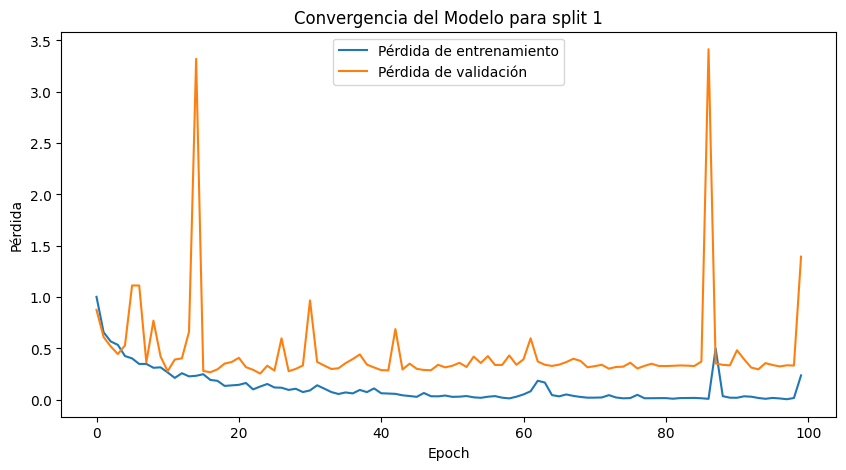

- CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        67
           1       0.90      0.84      0.87        67
           2       0.57      0.98      0.72        66
           3       0.92      0.97      0.94        67
           4       1.00      0.25      0.40        67

    accuracy                           0.78       334
   macro avg       0.85      0.79      0.76       334
weighted avg       0.85      0.78      0.76       334

- CONFUSION MATRIX



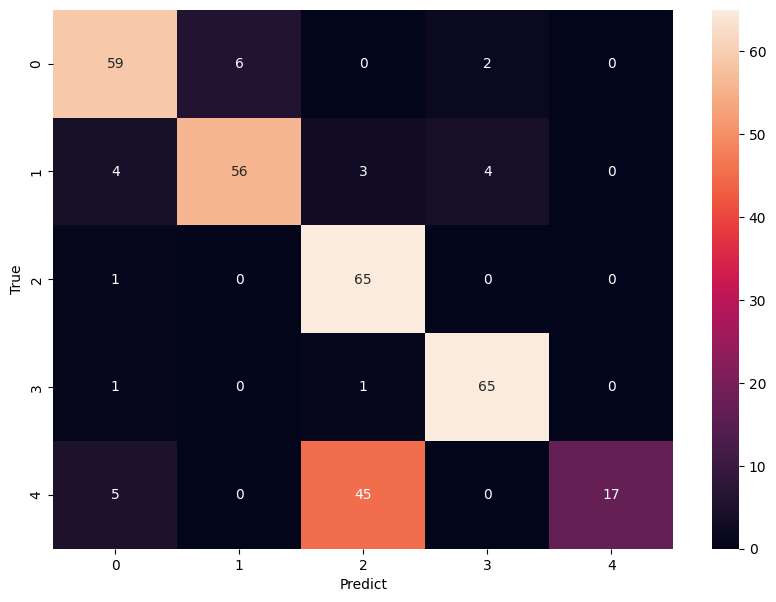


====================================== EVALUATION WITH SPLIT 2 =======================================


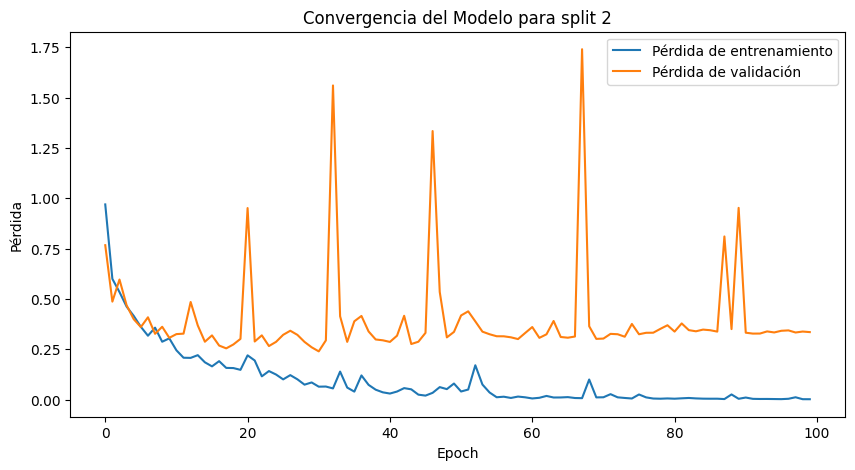

- CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        67
           1       0.89      0.94      0.91        66
           2       0.94      0.93      0.93        67
           3       0.95      0.93      0.94        67
           4       0.97      0.95      0.96        66

    accuracy                           0.92       333
   macro avg       0.93      0.93      0.93       333
weighted avg       0.93      0.92      0.93       333

- CONFUSION MATRIX



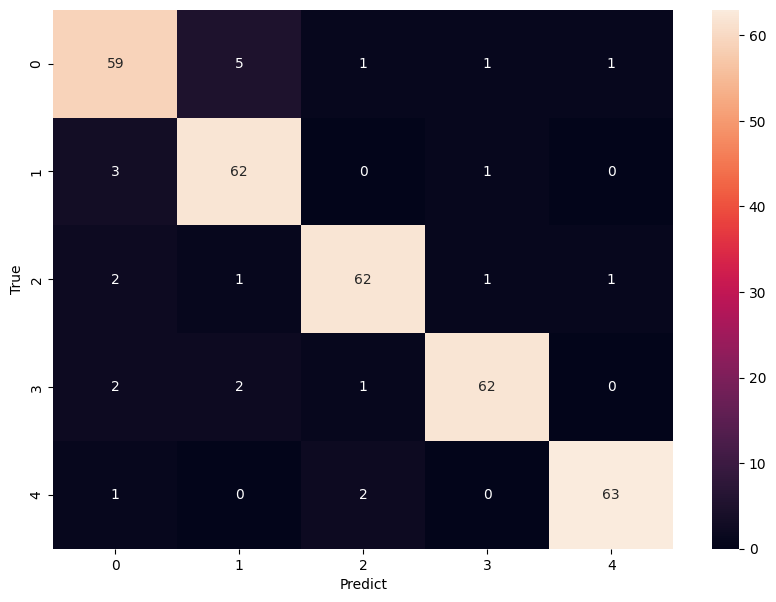


====================================== EVALUATION WITH SPLIT 3 =======================================


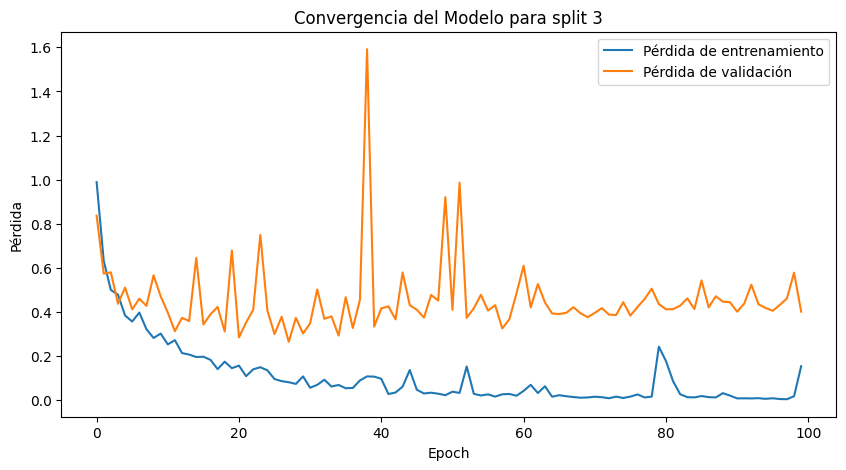

- CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        66
           1       0.85      0.96      0.90        67
           2       0.94      0.96      0.95        67
           3       0.91      0.97      0.94        66
           4       0.98      0.97      0.98        67

    accuracy                           0.93       333
   macro avg       0.94      0.93      0.93       333
weighted avg       0.94      0.93      0.93       333

- CONFUSION MATRIX



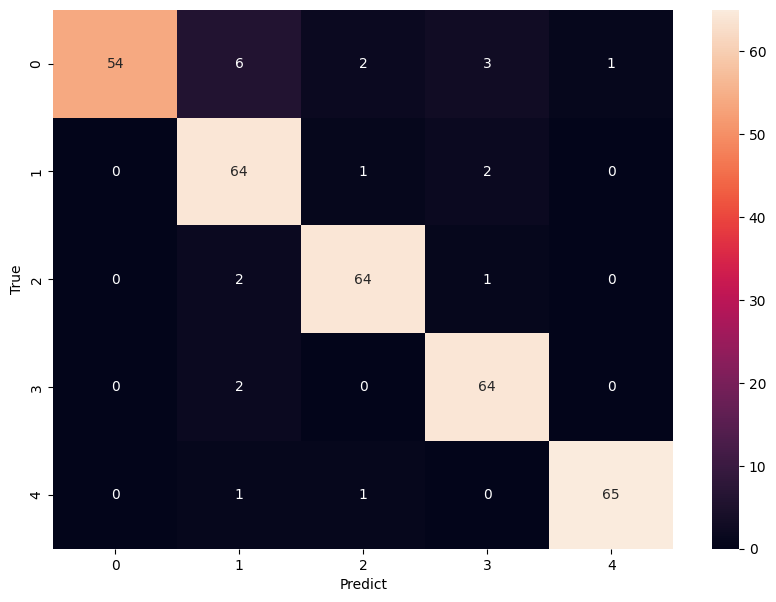

In [68]:
num_splits = 3
accuracies, precisions, recalls, f1s = [],[],[],[]

for split in range(1, num_splits + 1):
    print("\n======================================================================================================")
    print(f"====================================== EVALUATION WITH SPLIT {split} =======================================")
    
    X_train, y_train, X_test, y_test, y_train_OHE, y_test_OHE = load_data(split)
    model = create_model(
        layer_neurons=[100,50],
        activation_function='selu',
        optimizer=tf.keras.optimizers.SGD,
        loss_function='KLDivergence'
    )
    
    historia = model.fit(X_train, y_train_OHE, validation_data=(X_test, y_test_OHE), epochs=100, batch_size=8, verbose=0)

    plt.figure(figsize=(10,5))
    plt.plot(historia.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(historia.history['val_loss'], label='Pérdida de validación')
    plt.title(f'Convergencia del Modelo para split {split}')
    plt.xlabel('Epoch')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

    # HERE STARTS THE B)
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_OHE, axis=1)
    print("- CLASSIFICATION REPORT\n")
    print(classification_report(y_test_classes, y_pred_classes))
    print("- CONFUSION MATRIX\n")
    cm = confusion_matrix(y_test_classes, y_pred_classes)

    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predict')
    plt.ylabel('True')

    plt.show()

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)



#### c) Calculate and provide the average value for each metric.

In [71]:
avg_accuracy = np.mean(accuracies) 
avp_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1s = np.mean(f1s)

print(f'Average accuracy: {avg_accuracy}')
print(f'Average precision: {avp_precision}')
print(f'Average recall: {avg_recall}')
print(f'Average f1-score: {avg_f1s}')


Average accuracy: 0.8810966655278033
Average precision: 0.9038471571012007
Average recall: 0.8810966655278033
Average f1-score: 0.8728828969601827
